In [1]:
import scipy.spatial as spatial
import numpy as np
import matplotlib.pyplot as plt
from more_itertools import powerset
import mpl_toolkits.mplot3d as a3
from wireframes import wireframe_sphere
from rich import print
import gudhi as gd
from more_itertools import powerset
import time

In [2]:
X = np.asarray([
    [0,0],
    [0.5, 0],
    [0.25, 0.5 * np.sqrt(3)/2 ],
    [ 0.75/3, (0.5 * np.sqrt(3)/2)/3 ],
])
X = np.random.rand(4,3)
X = np.random.rand(10, 3)
dimension = X.shape[1]

In [3]:
def cayley_menger_matrix(X):
    d = X.shape[1]
    dm = np.power(spatial.distance_matrix(X,X), 2)
    m = np.zeros(np.asarray(dm.shape) + 1)
    m[:,0] = 1
    m[0,:] = 1
    m[0,0] = 0
    m[1:,1:] = dm
    return m

The Cartesian coordinates of any point are a weighted average
of the Cartesian coordinates of the triangle's vertices,
with the weights being the point's barycentric coordinates summing to unity. So e.g. for a triangle:
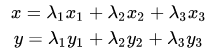

In [4]:
%matplotlib notebook
start_time = time.time()
#----------------------------------------------------------
if False:
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(projection = "3d") if dimension == 3 else fig.add_subplot()
else:
    ax = None

tri = list() if dimension == 3 else None
kdtree = spatial.KDTree(X) # X is in R^d
cech_complex = dict()

triangulation = spatial.Delaunay(X)
delaunay_complex = [ list(powerset(face)) for face in triangulation.simplices ]
delaunay_complex = set([ tuple(sorted(list(item))) for sublist in delaunay_complex for item in sublist])

if dimension == 3:
    for face in delaunay_complex:
        if len(face) == 3:
            tri.append(face)

filtration = { (i,) : 0.0 for i in range(X.shape[0]) }

for i in reversed(range(1, dimension + 1)):
    faces = [ f for f in delaunay_complex if len(f) == (i + 1) ]
    for f in faces:
        if f not in filtration:
            content_inv  = np.linalg.inv(cayley_menger_matrix( X[f,:] ))
            circumradius = np.sqrt(content_inv[0,0]/-2)
            circumcentre = content_inv[1:,0].dot( X[f,:] )
            filtration[f] = circumradius
        #
        subfaces = [ tuple(sorted(list(tau))) for tau in set(powerset(f)) if len(tau) > 1]
        for t in subfaces:
            if t in filtration:
                filtration[t] = min(filtration[t], filtration[f])
            else:
                content_inv  = np.linalg.inv(cayley_menger_matrix( X[t,:] ))
                circumradius = np.sqrt(content_inv[0,0]/-2)
                circumcentre = content_inv[1:,0].dot( X[t,:] )
                _,nn = kdtree.query(circumcentre, k = len(t))
                if set(nn) != set(t): # not Gabriel
                    filtration[t] = filtration[f]
            
            #---- PLOTTING
            if ax is not None:
                plot_color = { 2 : "black", 3 : "red", 4 : "blue" }
                plot_color = plot_color[len(t)]
                ax.scatter(
                    *tuple(circumcentre),
                    color = plot_color,
                    marker = "o",
                    facecolors='none',
                    s = 100,
                    alpha = 1
                )
                for y in X[t, :]:
                    connecting_lines = (
                        [circumcentre[0],y[0]],
                        [circumcentre[1],y[1]],
                        [circumcentre[2],y[2]]
                    ) if dimension == 3 else (
                        [circumcentre[0],y[0]],
                        [circumcentre[1],y[1]],
                    )
                    ax.plot(
                        *connecting_lines,
                        "--",
                        color = plot_color,
                        alpha = 0.4
                    )
                _,nn = kdtree.query(circumcentre, k = len(t))
                if set(nn) != set(t):
                    ax.scatter(
                        *tuple(circumcentre),
                        color = plot_color,
                        marker = "x",
                        s = 100,
                        alpha = 1
                    )
#

cech_complex = sorted(list(filtration.items()), key = lambda t : t[1])
#----------------------------------------------------------
print("--- %s seconds ---" % (time.time() - start_time))

if ax is not None:
    if dimension == 3:
        plt_tri = a3.art3d.Poly3DCollection(X[tri, :])
        plt_tri.set_alpha(0.1)
        plt_tri.set_color('grey')
        ax.add_collection3d(plt_tri)

    for i,x in enumerate(X):
        ax.scatter(*tuple(x), color = "blue")
        ax.text(*tuple(x+0.015), s=str(i))

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(0,1) if dimension == 3 else None
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z") if dimension == 3 else None
    plt.show()
print(cech_complex)

--- 0.06488370895385742 seconds ---

[
    ((0,), 0.0),
    ((1,), 0.0),
    ((2,), 0.0),
    ((3,), 0.0),
    ((4,), 0.0),
    ((5,), 0.0),
    ((6,), 0.0),
    ((7,), 0.0),
    ((8,), 0.0),
    ((9,), 0.0),
    ((4, 8), 0.05012348635010153),
    ((4, 5), 0.06142711977429907),
    ((5, 8), 0.06712617459261515),
    ((4, 5, 8), 0.07011855226475741),
    ((1, 8), 0.11358730602131675),
    ((1, 5), 0.127347721767284),
    ((1, 5, 8), 0.12773761818756116),
    ((1, 4), 0.1294022735596245),
    ((1, 4, 8), 0.1294022735596245),
    ((1, 4, 5, 8), 0.13329481228206103),
    ((1, 4, 5), 0.13329481228206103),
    ((0, 7), 0.14430943883216263),
    ((2, 8), 0.18010981534340886),
    ((2, 4), 0.1869626151795689),
    ((2, 4, 8), 0.1869626151795689),
    ((1, 2), 0.18723664213416355),
    ((1, 2, 8), 0.19344667161483325),
    ((0, 2), 0.19654782893824438),
    ((1, 2, 4, 8), 0.20192122914992042),
    ((1, 2, 4), 0.20192122914992042),
    ((2, 7), 0.22670141207897768),
    ((0, 2, 7), 0.22902652743534144),
    ((3, 6), 0.26734912725152715),
    ((0, 3), 0.3472800446306422),
    ((0, 9), 0.3683487842156713),
    ((3, 9), 0.3793629735363416),
    ((2, 3), 0.3830322396646711),
    ((0, 2, 3), 0.38465353716372547),
    ((0, 6), 0.38760018874012897),
    ((1, 9), 0.39701214534883567),
    ((0, 3, 6), 0.39783322028157153),
    ((6, 7), 0.40668913577406385),
    ((0, 6, 7), 0.4072112364757863),
    ((2, 6), 0.4193504994865239),
    ((0, 2, 6), 0.4208876902962233),
    ((0, 3, 9), 0.42227273807332705),
    ((0, 1), 0.42731869488290386),
    ((0, 1, 2), 0.42731869488290386),
    ((2, 9), 0.4282498727771042),
    ((0, 2, 9), 0.4282498727771042),
    ((1, 2, 9), 0.4284701472718803),
    ((2, 3, 6), 0.4286069219494948),
    ((0, 2, 3, 6), 0.42894469979927236),
    ((0, 1, 9), 0.4290389075468119),
    ((0, 1, 2, 9), 0.4290389075468119),
    ((0, 2, 6, 7), 0.43333668183886304),
    ((2, 6, 7), 0.43333668183886304),
    ((1, 3), 0.4345065384982421),
    ((1, 2, 3), 0.4345065384982421),
    ((2, 3, 9), 0.4643209299120046),
    ((0, 2, 3, 9), 0.4643209299120046),
    ((1, 3, 9), 0.4683350070830401),
    ((1, 2, 3, 9), 0.4695103702064266),
    ((3, 8), 0.4918822279593359),
    ((1, 3, 8), 0.4918822279593359),
    ((2, 3, 8), 0.4918822279593359),
    ((1, 2, 3, 8), 0.4918822279593359),
    ((6, 8), 0.5841828300245284),
    ((2, 6, 8), 0.5841828300245284),
    ((2, 3, 6, 8), 0.5856277335655112),
    ((3, 6, 8), 0.5856277335655112),
    ((4, 7), 0.7038236718054874),
    ((2, 4, 7), 0.7038236718054874),
    ((0, 1, 7), 1.2543563588941236),
    ((1, 7), 1.2543563588941236),
    ((0, 1, 2, 7), 1.2543563588941236),
    ((1, 2, 7), 1.2543563588941236),
    ((1, 2, 4, 7), 1.2880629714797491),
    ((1, 4, 7), 1.2880629714797491),
    ((1, 3, 5, 8), 1.296734618818024),
    ((1, 3, 5), 1.296734618818024),
    ((3, 5, 8), 1.296734618818024),
    ((3, 5), 1.296734618818024),
    ((2, 4, 6, 8), 1.307924257664565),
    ((2, 4, 6), 1.307924257664565),
    ((4, 6), 1.307924257664565),
    ((4, 6, 8), 1.307924257664565),
    ((2, 4, 6, 7), 1.3487375242727422),
    ((4, 6, 7), 1.3487375242727422),
    ((0, 1, 7, 9), 2.1678297816586505),
    ((7, 9), 2.1678297816586505),
    ((0, 7, 9), 2.1678297816586505),
    ((1, 7, 9), 2.1678297816586505),
    ((5, 6, 8), 3.369765255544424),
    ((5, 6), 3.369765255544424),
    ((3, 5, 6, 8), 3.369765255544424),
    ((3, 5, 6), 3.369765255544424),
    ((1, 4, 7, 9), 3.9780773768583177),
    ((4, 9), 3.9780773768583177),
    ((1, 4, 9), 3.9780773768583177),
    ((4, 7, 9), 3.9780773768583177),
    ((0, 3, 6, 9), 5.155547958350311),
    ((0, 6, 9), 5.155547958350311),
    ((6, 9), 5.155547958350311),
    ((3, 6, 9), 5.155547958350311),
    ((5, 9), 11.450632731275633),
    ((1, 5, 9), 11.450632731275633),
    ((4, 5, 6, 8), 17.4117490489779),
    ((4, 5, 6), 17.4117490489779),
    ((1, 4, 5, 9), 17.447809080165467),
    ((4, 5, 9), 17.447809080165467),
    ((1, 3, 5, 9), 20.87977967186944),
    ((3, 5, 9), 20.87977967186944)
]

In [5]:
start_time = time.time()
#----------------------------------------------------------
skeleton = gd.AlphaComplex(
    points = X
)
st = skeleton.create_simplex_tree()
gudhi_cech_complex = sorted(list(map(lambda t : (t[0],np.sqrt(t[1])), st.get_filtration())), key = lambda t : t[1])
#----------------------------------------------------------
print("--- %s seconds ---" % (time.time() - start_time))

_new_complex = list()
for face in gudhi_cech_complex:
    f = face[0]
    verts = [skeleton.get_point(idx) for idx in f]
    _new_complex.append(
        (tuple(sorted([ [tuple(x) for x in X].index(tuple(v)) for v in verts ])), face[1])
    )
print(_new_complex)

--- 0.0006887912750244141 seconds ---

[
    ((3,), 0.0),
    ((6,), 0.0),
    ((7,), 0.0),
    ((0,), 0.0),
    ((9,), 0.0),
    ((1,), 0.0),
    ((2,), 0.0),
    ((4,), 0.0),
    ((8,), 0.0),
    ((5,), 0.0),
    ((4, 8), 0.050123486350101526),
    ((4, 5), 0.061427119774299065),
    ((5, 8), 0.06712617459261515),
    ((4, 5, 8), 0.07011855226475742),
    ((1, 8), 0.11358730602131675),
    ((1, 5), 0.127347721767284),
    ((1, 5, 8), 0.12773761818756116),
    ((1, 4), 0.1294022735596245),
    ((1, 4, 8), 0.1294022735596245),
    ((1, 4, 5), 0.133294812282061),
    ((1, 4, 5, 8), 0.133294812282061),
    ((0, 7), 0.14430943883216266),
    ((2, 8), 0.18010981534340886),
    ((2, 4), 0.18696261517956886),
    ((2, 4, 8), 0.18696261517956886),
    ((1, 2), 0.18723664213416358),
    ((1, 2, 8), 0.19344667161483328),
    ((0, 2), 0.19654782893824435),
    ((1, 2, 4), 0.20192122914992044),
    ((1, 2, 4, 8), 0.20192122914992044),
    ((2, 7), 0.2267014120789777),
    ((0, 2, 7), 0.22902652743534144),
    ((3, 6), 0.26734912725152715),
    ((0, 3), 0.3472800446306422),
    ((0, 9), 0.3683487842156713),
    ((3, 9), 0.3793629735363416),
    ((2, 3), 0.3830322396646711),
    ((0, 2, 3), 0.38465353716372547),
    ((0, 6), 0.38760018874012897),
    ((1, 9), 0.3970121453488357),
    ((0, 3, 6), 0.3978332202815715),
    ((6, 7), 0.40668913577406385),
    ((0, 6, 7), 0.40721123647578633),
    ((2, 6), 0.4193504994865239),
    ((0, 2, 6), 0.42088769029622336),
    ((0, 3, 9), 0.42227273807332705),
    ((0, 1), 0.4273186948829038),
    ((0, 1, 2), 0.4273186948829038),
    ((2, 9), 0.42824987277710425),
    ((0, 2, 9), 0.42824987277710425),
    ((1, 2, 9), 0.4284701472718805),
    ((2, 3, 6), 0.42860692194949485),
    ((0, 2, 3, 6), 0.42894469979927236),
    ((0, 1, 9), 0.4290389075468122),
    ((0, 1, 2, 9), 0.4290389075468122),
    ((2, 6, 7), 0.4333366818388631),
    ((0, 2, 6, 7), 0.4333366818388631),
    ((1, 3), 0.43450653849824206),
    ((1, 2, 3), 0.43450653849824206),
    ((2, 3, 9), 0.46432092991200463),
    ((0, 2, 3, 9), 0.46432092991200463),
    ((1, 3, 9), 0.46833500708304004),
    ((1, 2, 3, 9), 0.4695103702064266),
    ((3, 8), 0.49188222795933617),
    ((1, 3, 8), 0.49188222795933617),
    ((2, 3, 8), 0.49188222795933617),
    ((1, 2, 3, 8), 0.49188222795933617),
    ((6, 8), 0.584182830024528),
    ((2, 6, 8), 0.584182830024528),
    ((3, 6, 8), 0.5856277335655106),
    ((2, 3, 6, 8), 0.5856277335655106),
    ((4, 7), 0.7038236718054872),
    ((2, 4, 7), 0.7038236718054872),
    ((1, 7), 1.2543563588941127),
    ((0, 1, 7), 1.2543563588941127),
    ((1, 2, 7), 1.2543563588941127),
    ((0, 1, 2, 7), 1.2543563588941127),
    ((1, 4, 7), 1.2880629714797442),
    ((1, 2, 4, 7), 1.2880629714797442),
    ((3, 5), 1.2967346188180109),
    ((1, 3, 5), 1.2967346188180109),
    ((3, 5, 8), 1.2967346188180109),
    ((1, 3, 5, 8), 1.2967346188180109),
    ((4, 6), 1.30792425766459),
    ((2, 4, 6), 1.30792425766459),
    ((4, 6, 8), 1.30792425766459),
    ((2, 4, 6, 8), 1.30792425766459),
    ((4, 6, 7), 1.348737524272743),
    ((2, 4, 6, 7), 1.348737524272743),
    ((7, 9), 2.167829781658652),
    ((0, 7, 9), 2.167829781658652),
    ((1, 7, 9), 2.167829781658652),
    ((0, 1, 7, 9), 2.167829781658652),
    ((5, 6), 3.3697652555445528),
    ((3, 5, 6), 3.3697652555445528),
    ((5, 6, 8), 3.3697652555445528),
    ((3, 5, 6, 8), 3.3697652555445528),
    ((4, 9), 3.9780773768586837),
    ((4, 7, 9), 3.9780773768586837),
    ((1, 4, 9), 3.9780773768586837),
    ((1, 4, 7, 9), 3.9780773768586837),
    ((6, 9), 5.15554795835006),
    ((3, 6, 9), 5.15554795835006),
    ((0, 6, 9), 5.15554795835006),
    ((0, 3, 6, 9), 5.15554795835006),
    ((5, 9), 11.450632731271881),
    ((1, 5, 9), 11.450632731271881),
    ((4, 5, 6), 17.411749049016773),
    ((4, 5, 6, 8), 17.411749049016773),
    ((4, 5, 9), 17.44780908015461),
    ((1, 4, 5, 9), 17.44780908015461),
    ((3, 5, 9), 20.87977967184229),
    ((1, 3, 5, 9), 20.87977967184229)
]

In [6]:
my_values = [ t[1] for t in cech_complex ]
gd_values = [ t[1] for t in gudhi_cech_complex ]
vals = list(zip(my_values, gd_values))
checker = list(map(lambda v : np.abs(v[0] - v[1]), vals))
close_val_check = np.allclose(checker, 0)
print('Filtration values are all close: ' + str(close_val_check))
if not close_val_check:
    a = np.asarray(checker)
    c = np.logical_not(np.isclose(checker, 0))
    s = sum([1 for x in c if x])
    print(str(s)+' filtration values were different: ')
    print(a[c])

Filtration values are all close: True